In [ ]:
# Download US power output PV Watts (version 8) from 

In [ ]:
# Documentation: https://developer.nrel.gov/docs/api-key/
# https://pvwatts.nrel.gov/downloads/pvwattsv5.pdf

In [1]:
import numpy as np
import scipy as sp
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [8]:
hrh_apikey = 'GNoTfD5IZWwIEz24zB5Wn0aEhDvNJSep5bwapzTI'
data_path = '/Users/hrh/Desktop/AI/erdos/rapower_data/'

In [3]:
# 1. Define PVWatts parameters and your API key
parameters = {
    'format': 'json',
    'system_capacity': 1000,
    'module_type': 0,
    'losses': 14.08,
    'array_type': 1,
    'tilt': 40,
    'azimuth': 180,
    'lat': 40.0099983215332,
    'lon':  -105.2600021362305,
    'dataset': 'tmy2',
    'radius': 25,
    'timeframe': 'monthly',
    'api_key': hrh_apikey  # Replace with your API key
}



In [4]:
# url = 'https://developer.nrel.gov/api/pvwatts/v8'

# # 2. Send request
# response = requests.get(url, params=parameters)
# data = response.json()

# # 3. Convert the output data to a DataFrame
# df = pd.DataFrame(data['outputs'])

# print(response)

<Response [200]>


In [4]:
##### Try to get data for California on a grid with lat_delta and lon_delta resolution
lat_delta = 0.25
lon_delta = 0.25

# #CONUS box
# top = 49.3457868 # north lat
# left = -124.7844079 # west long
# right = -66.9513812 # east long
# bottom =  24.7433195 # south lat

#California box
top    = 42.009518
bottom = 32.534156
left   = -124.409591 
right  =  -114.131211

In [5]:
# 1. Define a list of latitudes and longitudes for CONUS
lats = list(np.arange(bottom, top, lat_delta))  # from southernmost to northernmost points with a 5-degree step
lons = list(np.arange(left, right, lon_delta))  # from westernmost to easternmost points with a 5-degree step

all_data = []


In [6]:
# %%time
# for lat in lats:
#     for lon in lons:
#         parameters = {
#             'format': 'json',
#             'system_capacity': 1000, #1000kW = 1 MW, 1 MW or greater is considered utility-scale
#             'module_type': 0,       # 0- Standard module, 1- Permium, 2-Thin film
#             'losses': 14,           # Losses in percentage
#             'array_type': 0,        # Open Rack: Also known as ground mount.
#             'tilt': 40,
#             'azimuth': 180,         # This means that the solar array is facing South in the Northeren Hemisphere
#             'lat': lat,
#             'lon': lon,
#             'dataset': 'tmy2',      #tmy2 is 1960-1990
#             'radius': 0,            # Pick the station nearest to the given (lat,lon)
#             'timeframe': 'hourly',
#             'api_key': hrh_apikey
#         }

#         url = 'https://developer.nrel.gov/api/pvwatts/v8'
#         response = requests.get(url, params=parameters)
#         data = response.json()
             
#         # Extract and append relevant data to the all_data list
#         # Extract relevant data
#         print('Processing (lat,lon):',lat,lon,'\n')
        
#         # Check if 'outputs' is in the data
#         if 'outputs' not in data:
#             print(f"No data available for latitude {lat} and longitude {lon}")
#             continue

#         output_data = data['outputs']
#         input_data  = data['inputs']

#         output_data['latitude']  = input_data['lat']
#         output_data['longitude'] = input_data['lon']
#         all_data.append(output_data)
        
        
# # Convert all_data to a DataFrame
# df = pd.DataFrame(all_data)

# print(df)

In [14]:
df

,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,solrad_annual,capacity_factor,ac,poa,dn,dc,df,tamb,tcell,wspd,alb,latitude,longitude
0,"[461.4913558542934, 473.2026110319821, 563.968...","[143.4127180269144, 147.1415451775317, 176.455...","[4.626216710545626, 5.255055184911845, 5.69212...","[483.8168806266701, 496.2168457788466, 591.325...",6.699212e+03,5.770376,19.118756,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 136.76, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.395, 30...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 193.0, 368...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.22, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 75.0...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 6.3, 8.7, ...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 7.978, 17....","[0.5, 0.7, 0.8, 1.0, 1.2, 1.3, 1.5, 1.5, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",32.534156,-124.409591
1,"[461.4913558542934, 473.2026110319821, 563.968...","[143.4127180269144, 147.1415451775317, 176.455...","[4.626216710545626, 5.255055184911845, 5.69212...","[483.8168806266701, 496.2168457788466, 591.325...",6.699212e+03,5.770376,19.118756,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 136.76, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.395, 30...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 193.0, 368...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.22, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 75.0...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 6.3, 8.7, ...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 7.978, 17....","[0.5, 0.7, 0.8, 1.0, 1.2, 1.3, 1.5, 1.5, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",32.534156,-124.159591
2,"[461.4913558542934, 473.2026110319821, 563.968...","[143.4127180269144, 147.1415451775317, 176.455...","[4.626216710545626, 5.255055184911845, 5.69212...","[483.8168806266701, 496.2168457788466, 591.325...",6.699212e+03,5.770376,19.118756,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 136.76, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.395, 30...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 193.0, 368...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.22, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 75.0...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 6.3, 8.7, ...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 7.978, 17....","[0.5, 0.7, 0.8, 1.0, 1.2, 1.3, 1.5, 1.5, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",32.534156,-123.909591
3,"[461.4913558542934, 473.2026110319821, 563.968...","[143.4127180269144, 147.1415451775317, 176.455...","[4.626216710545626, 5.255055184911845, 5.69212...","[483.8168806266701, 496.2168457788466, 591.325...",6.699212e+03,5.770376,19.118756,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 136.76, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.395, 30...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 193.0, 368...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.22, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 75.0...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 6.3, 8.7, ...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 7.978, 17....","[0.5, 0.7, 0.8, 1.0, 1.2, 1.3, 1.5, 1.5, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",32.534156,-123.659591
4,"[461.4913558542934, 473.2026110319821, 563.968...","[143.4127180269144, 147.1415451775317, 176.455...","[4.626216710545626, 5.255055184911845, 5.69212...","[483.8168806266701, 496.2168457788466, 591.325...",6.699212e+03,5.770376,19.118756,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 136.76, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.395, 30...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 193.0, 368...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.22, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 75.0...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 6.3, 8.7, ...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 7.978, 17....","[0.5, 0.7, 0.8, 1.0, 1.2, 1.3, 1.5, 1.5, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",32.534156,-123.409591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,"[139580.4552153377, 131386.5113831204, 169218....","[172.8580609034132, 167.5447390244193, 215.178...","[5.576066

In [15]:
# df.to_csv('pvwatts_monthly_ca0.25_1960_1990.csv',index=False)

In [10]:
df1 = pd.read_csv(data_path+'pvwatts_monthly_ca0.25_1960_1990.csv')
df1

,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,solrad_annual,capacity_factor,ac,poa,dn,dc,df,tamb,tcell,wspd,alb,latitude,longitude
0,"[461.4913558542934, 473.2026110319821, 563.968...","[143.4127180269144, 147.1415451775317, 176.455...","[4.626216710545626, 5.255055184911845, 5.69212...","[483.8168806266701, 496.2168457788466, 591.325...",6.699212e+03,5.770376,19.118756,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 136.76, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.395, 30...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 193.0, 368...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.22, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 75.0...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 6.3, 8.7, ...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 7.978, 17....","[0.5, 0.7, 0.8, 1.0, 1.2, 1.3, 1.5, 1.5, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",32.534156,-124.409591
1,"[461.4913558542934, 473.2026110319821, 563.968...","[143.4127180269144, 147.1415451775317, 176.455...","[4.626216710545626, 5.255055184911845, 5.69212...","[483.8168806266701, 496.2168457788466, 591.325...",6.699212e+03,5.770376,19.118756,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 136.76, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.395, 30...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 193.0, 368...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.22, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 75.0...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 6.3, 8.7, ...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 7.978, 17....","[0.5, 0.7, 0.8, 1.0, 1.2, 1.3, 1.5, 1.5, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",32.534156,-124.159591
2,"[461.4913558542934, 473.2026110319821, 563.968...","[143.4127180269144, 147.1415451775317, 176.455...","[4.626216710545626, 5.255055184911845, 5.69212...","[483.8168806266701, 496.2168457788466, 591.325...",6.699212e+03,5.770376,19.118756,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 136.76, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.395, 30...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 193.0, 368...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.22, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 75.0...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 6.3, 8.7, ...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 7.978, 17....","[0.5, 0.7, 0.8, 1.0, 1.2, 1.3, 1.5, 1.5, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",32.534156,-123.909591
3,"[461.4913558542934, 473.2026110319821, 563.968...","[143.4127180269144, 147.1415451775317, 176.455...","[4.626216710545626, 5.255055184911845, 5.69212...","[483.8168806266701, 496.2168457788466, 591.325...",6.699212e+03,5.770376,19.118756,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 136.76, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.395, 30...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 193.0, 368...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.22, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 75.0...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 6.3, 8.7, ...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 7.978, 17....","[0.5, 0.7, 0.8, 1.0, 1.2, 1.3, 1.5, 1.5, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",32.534156,-123.659591
4,"[461.4913558542934, 473.2026110319821, 563.968...","[143.4127180269144, 147.1415451775317, 176.455...","[4.626216710545626, 5.255055184911845, 5.69212...","[483.8168806266701, 496.2168457788466, 591.325...",6.699212e+03,5.770376,19.118756,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 136.76, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 73.395, 30...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 193.0, 368...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 158.22, 10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 75.0...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 6.3, 8.7, ...","[6.6, 6.0, 5.4, 5.0, 4.8, 4.1, 3.9, 7.978, 17....","[0.5, 0.7, 0.8, 1.0, 1.2, 1.3, 1.5, 1.5, 1.5, ...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",32.534156,-123.409591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,"[139580.4552153377, 131386.5113831204, 169218....","[172.8580609034132, 167.5447390244193, 215.178...","[5.576066

In [11]:
# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(df1['longitude'], df1['latitude'])]
geo_df   = gpd.GeoDataFrame(df1, geometry=geometry)

The coordinate reference system for this file: EPSG:3857 EPSG:4326


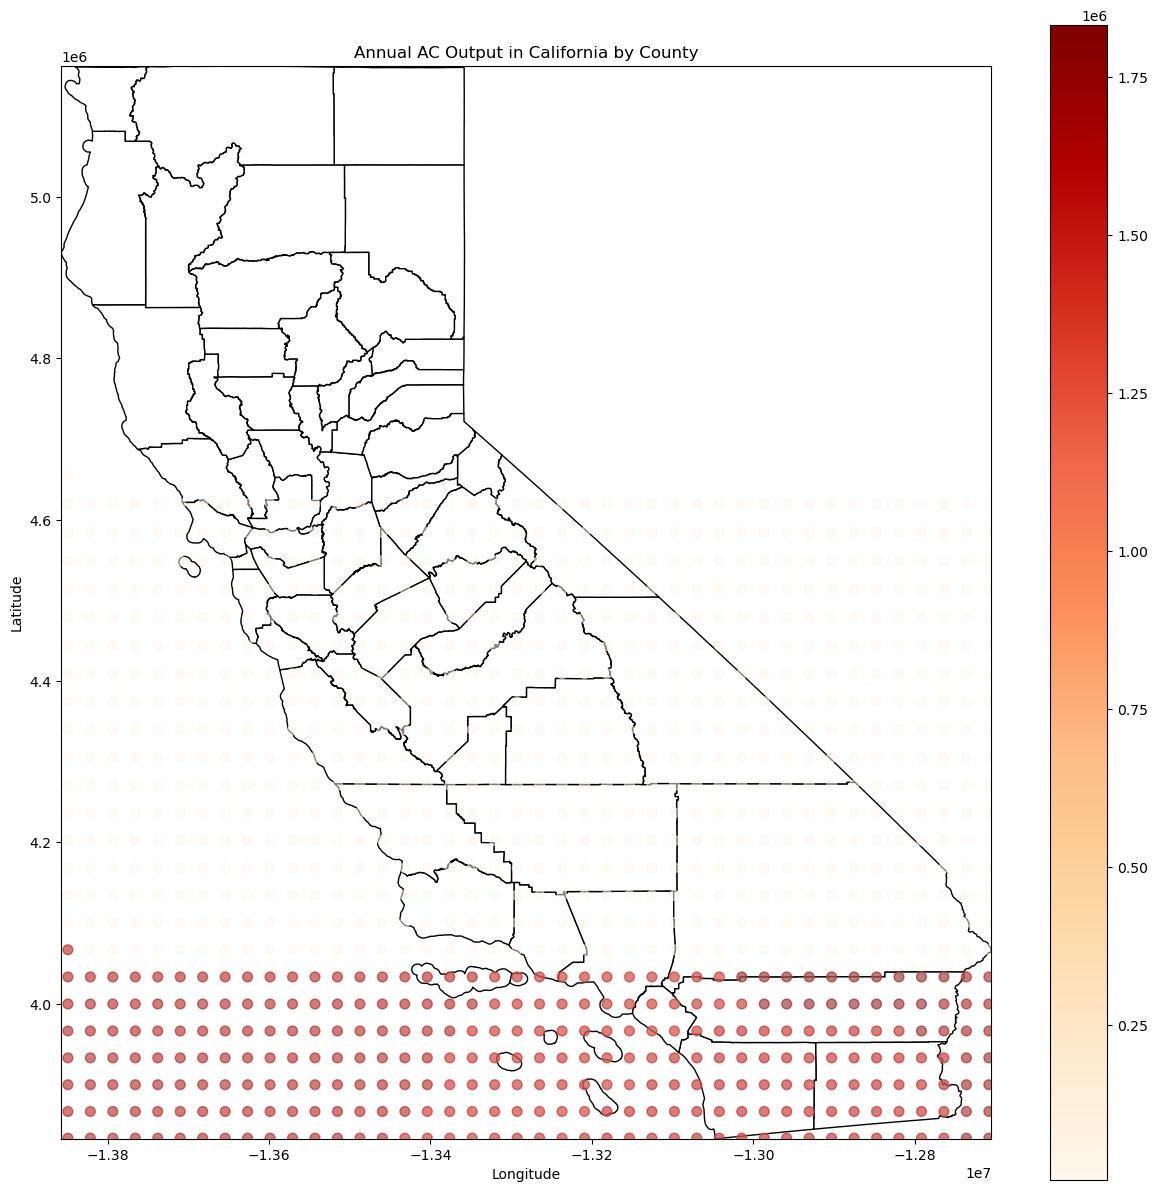

In [17]:
# Read the California county boundaries shapefile
ca_counties = gpd.read_file(data_path+ 'CA_counties/CA_Counties_TIGER2016.shp')

geo_df.crs = "EPSG:4326" #Setting the crs of geo_df
print('The coordinate reference system for this file:',ca_counties.crs,geo_df.crs)


# Ensure that your data is in the same CRS as the shapefile
geo_df = geo_df.to_crs(ca_counties.crs)

# Plot the county boundaries
fig, ax = plt.subplots(figsize=(15, 15))
ca_counties.plot(ax=ax, color='white', edgecolor='black')

# Plot your data on top of the county boundaries
geo_df.plot(ax=ax, column='ac_annual', legend=True, markersize=50, cmap='OrRd', alpha=0.5)

# Add titles and labels as needed
plt.title("Annual AC Output in California by County")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Optionally, adjust the plot limits to the extent of the shapefile or your data points
ax.set_xlim(ca_counties.bounds.minx.min(), ca_counties.bounds.maxx.max())
ax.set_ylim(ca_counties.bounds.miny.min(), ca_counties.bounds.maxy.max())

# Display the plot
plt.show()

/var/folders/k1/5_y16ccj4zv7lcjp767yd1b80000gn/T/ipykernel_1699/3706103910.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


ValueError: aspect must be finite and positive 

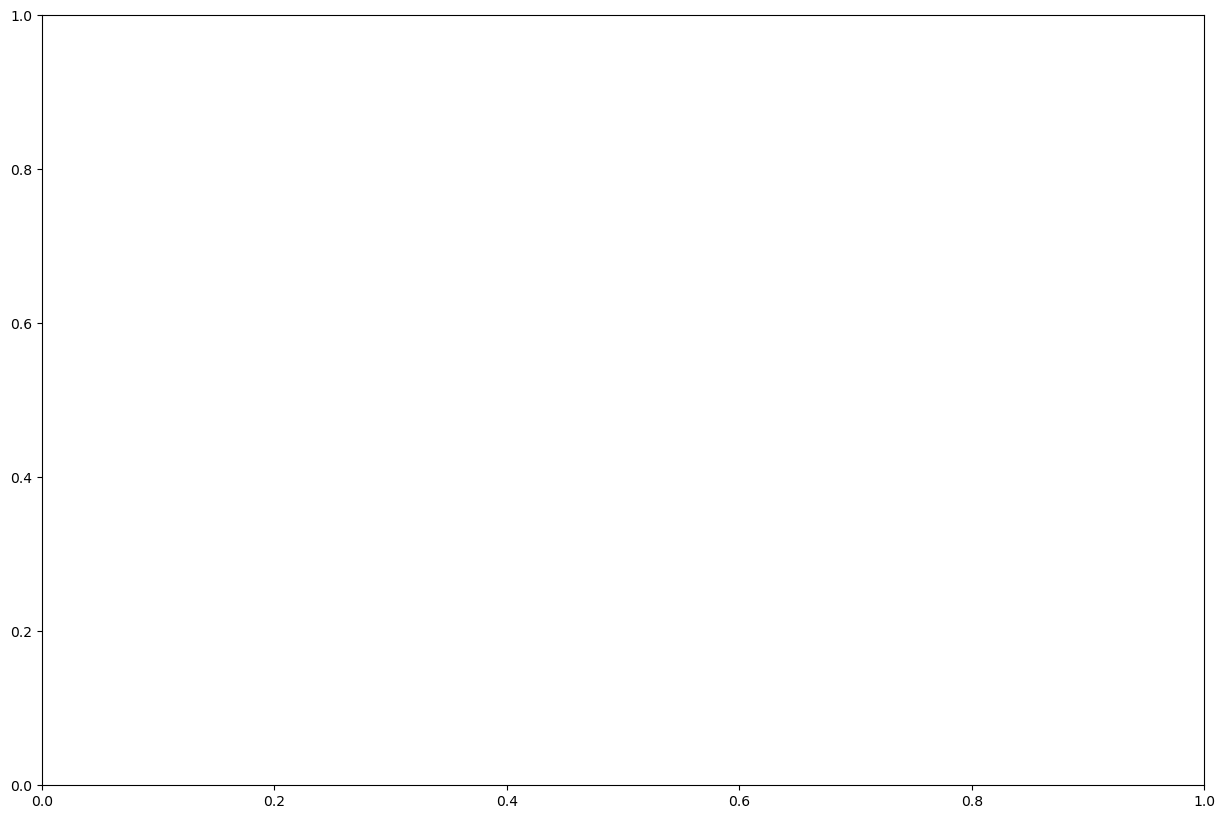

In [20]:
# Load US boundaries and plot
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#us = world[world.name == "United States of America"]
ca  = world[world.name=='California']

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ca.plot(ax=ax, color='lightgray')
geo_df.plot(ax=ax, column='ac_annual', legend=True, markersize=50, cmap='OrRd')  # Use the column parameter
plt.title("Annual AC Output on California")
plt.show()

In [ ]:
# {
  # "inputs": {
  #   "api_key": "DEMO_KEY",
  #   "azimuth": "180",
  #   "system_capacity": "4",
  #   "losses": "14",
  #   "array_type": "1",
  #   "module_type": "0",
  #   "gcr": "0.4",
  #   "dc_ac_ratio": "1.2",
  #   "inv_eff": "96.0",
  #   "radius": "0",
  #   "dataset": "nsrdb",
  #   "tilt": "10",
  #   "address": "boulder, co",
  #   "soiling": [
  #     12.0,
  #     4.0,
  #     45.0,
  #     23.0,
  #     9.0,
  #     99.0,
  #     67.0,
  #     12.54,
  #     54.0,
  #     9.0,
  #     0.0,
  #     7.6
  #   ],
  #   "albedo": "0.3",
  #   "bifaciality": "0.7"
  # },
  # "errors": [],
  # "warnings": [],
  # "version": "8.0.0",
  # "ssc_info": {
  #   "version": 275,
  #   "build": "Linux 64 bit GNU/C++ Oct  4 2022 03:10:07",
  #   "module": "pvwattsv8"
  # },
  # "station_info": {
  #   "lat": 40.0099983215332,
  #   "lon": -105.2600021362305,
  #   "elev": 1635.640014648438,
  #   "tz": -7.0,
  #   "location": "149190",
  #   "city": "",
  #   "state": "Colorado",
  #   "solar_resource_file": "149190.csv",
  #   "weather_data_source": "NSRDB PSM V3 GOES tmy-2020 3.2.0"
  # }